In [ ]:
#include <driver/i2s.h>
#include <WiFi.h>

// Cấu hình chân I2S
#define I2S_WS  15  // Word Select (WS) -> D15
#define I2S_SCK 26  // Serial Clock (SCK) -> D26
#define I2S_SD  33  // Serial Data (SD) -> D33
#define BUFFER_SIZE 1024

const char* ssid = "WIN10";  // Thay bằng WiFi của bạn
const char* password = "00000000";
char server_ip[16];  // Địa chỉ IP của máy tính chạy server
const uint16_t server_port = 12345;

WiFiClient client;

// Cấu hình I2S
void setupI2S() {
  i2s_config_t i2s_config = {
    .mode = (i2s_mode_t)(I2S_MODE_MASTER | I2S_MODE_RX),
    .sample_rate = 16000, // Tần số lấy mẫu
    .bits_per_sample = I2S_BITS_PER_SAMPLE_16BIT,
    .channel_format = I2S_CHANNEL_FMT_ONLY_LEFT,
    .communication_format = I2S_COMM_FORMAT_I2S_MSB,
    .intr_alloc_flags = ESP_INTR_FLAG_LEVEL1,
    .dma_buf_count = 16,
    .dma_buf_len = 216,
    .use_apll = false,
    .tx_desc_auto_clear = false,
    .fixed_mclk = 0
  };

  i2s_pin_config_t pin_config = {
    .bck_io_num = I2S_SCK,
    .ws_io_num = I2S_WS,
    .data_out_num = I2S_PIN_NO_CHANGE,
    .data_in_num = I2S_SD
  };

  i2s_driver_install(I2S_NUM_0, &i2s_config, 0, NULL);
  i2s_set_pin(I2S_NUM_0, &pin_config);
  i2s_set_clk(I2S_NUM_0, 16000, I2S_BITS_PER_SAMPLE_32BIT, I2S_CHANNEL_MONO);
}

void setup() {
  Serial.begin(115200);
    WiFi.begin(ssid, password);
  while (WiFi.status() != WL_CONNECTED) {
    delay(1000);
    Serial.println("Đang kết nối WiFi...");
  }
  strcpy(server_ip, WiFi.gatewayIP().toString().c_str());
  Serial.print("Đã kết nối WiFi!, IP: ");
  Serial.println(WiFi.gatewayIP());
  setupI2S();
  Serial.println("I2S đã khởi động.");
}

void loop() {
  if (!client.connected()) {
    Serial.print("Đang kết nối đến server...");
    Serial.print(server_ip);
    Serial.println("");
    if (client.connect(server_ip, server_port)) {
      Serial.println("Đã kết nối đến server!");
    } else {
      Serial.println("Kết nối thất bại.");
      delay(2000);
      return;
    }
  }

  int32_t sample[BUFFER_SIZE]; //biến chứa dữ liệu âm thanh
  size_t bytesRead; // số byte thực tế đọc được
  int16_t processed_sample[BUFFER_SIZE]; // Mảng chứa dữ liệu 16-bit để gửi

  // Đọc dữ liệu từ INMP441
  i2s_read(I2S_NUM_0, sample, sizeof(sample), &bytesRead, portMAX_DELAY);

  // Chuyển đổi dữ liệu để hiển thị
    for (int i = 0; i < BUFFER_SIZE; i++) {
    processed_sample[i] = (sample[i] >> 16) & 0xFFFF;  // Chuyển từ 32-bit về 16-bit
    // Serial.println(processed_sample[i]);
  }
  client.write((uint8_t*)processed_sample, sizeof(processed_sample));
}


In [5]:
from scipy.io import wavfile

# Đọc file âm thanh
sr, audio_array = wavfile.read(r"D:\Workspace\Python\Enjoy\temp_audio.wav")

print(f"Tần số lấy mẫu: {sr} Hz")
print(f"Kích thước mảng: {audio_array.shape}")
print(f"Một phần dữ liệu: {audio_array[:10]}")


Tần số lấy mẫu: 16000 Hz
Kích thước mảng: (80128,)
Một phần dữ liệu: [0 0 0 0 0 0 0 0 0 0]


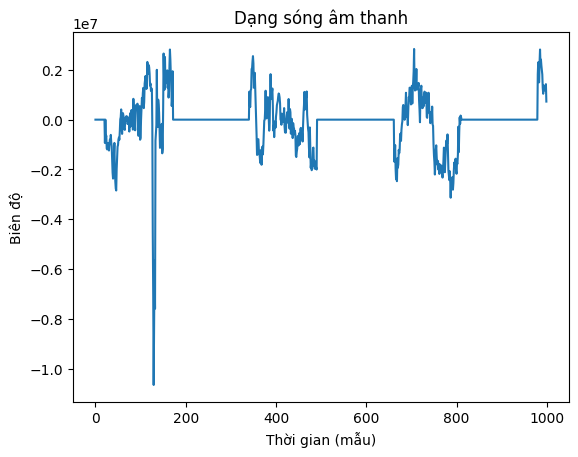

In [6]:
import matplotlib.pyplot as plt

plt.plot(audio_array[:1000])  # Vẽ 1000 mẫu đầu tiên
plt.title("Dạng sóng âm thanh")
plt.xlabel("Thời gian (mẫu)")
plt.ylabel("Biên độ")
plt.show()


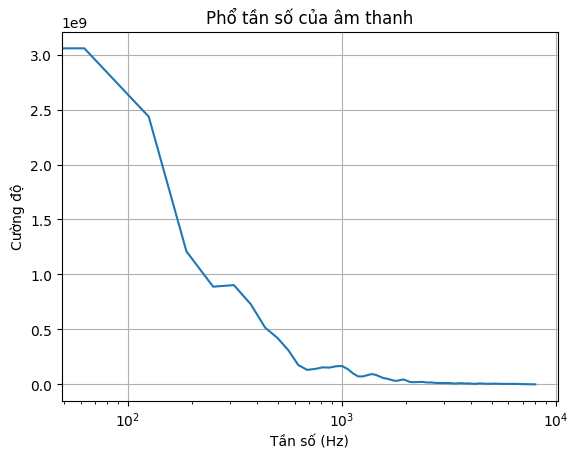

In [7]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
from scipy.io import wavfile

# Đọc file âm thanh
sr, audio = wavfile.read(r"D:\Workspace\Python\Enjoy\temp_audio.wav")

# Tính phổ tần số bằng FFT (Fourier Transform)
freqs, power = scipy.signal.welch(audio, sr)

# Vẽ biểu đồ tần số
plt.semilogx(freqs, power)
plt.xlabel("Tần số (Hz)")
plt.ylabel("Cường độ")
plt.title("Phổ tần số của âm thanh")
plt.grid()
plt.show()


In [ ]:
import numpy as np
import scipy.io.wavfile as wav
import scipy.fftpack

# # Đọc file WAV
# sampling_rate, signal = wav.read(r'D:\Workspace\Python\Enjoy\temp_audio.wav')  # Thay 'input.wav' bằng tên file của bạn
# print(sampling_rate,signal)
# # Nếu file là stereo, chỉ lấy kênh mono (chỉ một kênh)
# if len(signal.shape) == 2:
#     signal = signal[:, 0]
sampling_rate = 8
signal = np.array([0,1,0,1,0,1,0,1])
# Chuyển tín hiệu từ miền thời gian sang miền tần số bằng FFT
signal_fft = np.fft.fft(signal)
print(signal_fft)

# Tạo mảng tần số tương ứng với các giá trị trong FFT
frequencies = np.fft.fftfreq(len(signal), d=1/sampling_rate)

print(frequencies)
# Dải tần số con người nói (85 Hz đến 255 Hz)
min_freq = 0
max_freq = 8

# Tìm các chỉ số của tần số trong phạm vi cần giữ
indices = np.where((frequencies >= min_freq) & (frequencies <= max_freq))
print(indices)

# Tạo mảng FFT mới, chỉ giữ các tần số trong dải 85Hz đến 255Hz
filtered_signal_fft = np.zeros_like(signal_fft)
filtered_signal_fft[indices] = signal_fft[indices]
print(filtered_signal_fft)


# Đảm bảo giữ tần số đối xứng cho FFT (do FFT là đối xứng)
filtered_signal_fft[-indices[0]] = np.conj(filtered_signal_fft[indices])

# Chuyển về miền thời gian bằng IFFT
filtered_signal = np.fft.ifft(filtered_signal_fft)
print(filtered_signal)


# Chuyển tín hiệu về dạng thực (bỏ phần ảo)
filtered_signal = np.real(filtered_signal)

# Lưu tín hiệu đã lọc vào file WAV mới
# Chuyển đổi giá trị tín hiệu về kiểu dữ liệu int16 (tương thích với định dạng WAV)
filtered_signal = np.int16(filtered_signal)
print(filtered_signal)
# # Lưu tín hiệu đã lọc vào file mới
# wav.write('filtered_output.wav', sampling_rate, filtered_signal)

# print("Tín hiệu đã được lọc và lưu vào 'filtered_output.wav'")


[ 4.+0.j  0.+0.j  0.+0.j  0.+0.j -4.+0.j  0.+0.j  0.+0.j  0.+0.j]
[ 0.  1.  2.  3. -4. -3. -2. -1.]
(array([0, 1, 2, 3]),)
[4.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
[0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j 0.5-0.j]
[0 0 0 0 0 0 0 0]


[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49. -50. -49. -48. -47. -46. -45.
 -44. -43. -42. -41. -40. -39. -38. -37. -36. -35. -34. -33. -32. -31.
 -30. -29. -28. -27. -26. -25. -24. -23. -22. -21. -20. -19. -18. -17.
 -16. -15. -14. -13. -12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.
  -2.  -1.]


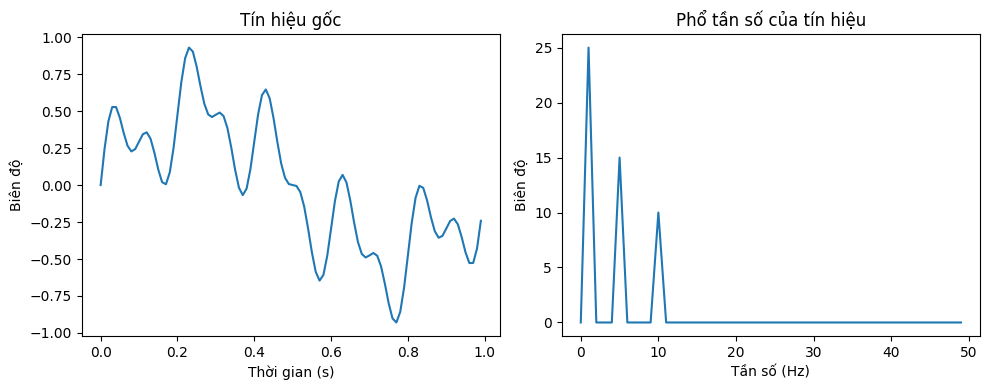

[10]


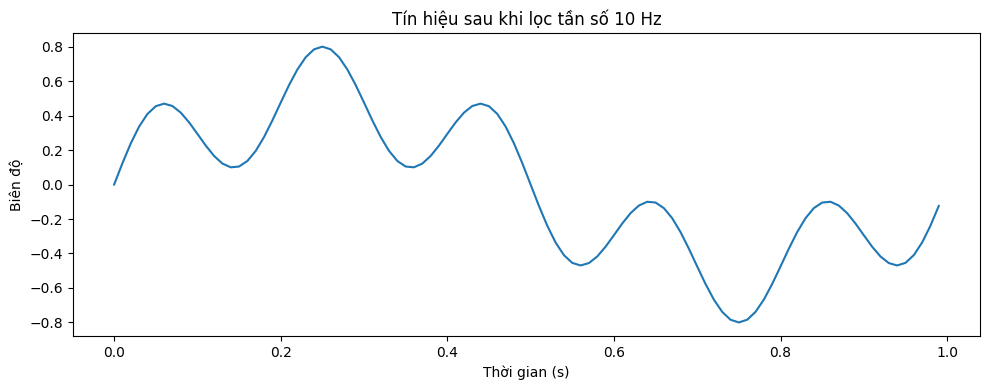

Tín hiệu đã lọc:  [ 1.31111858e-16  1.24100358e-01  2.39002192e-01  3.36395756e-01
  4.09661898e-01  4.54508497e-01  4.69379231e-01  4.55594744e-01
  4.17212413e-01  3.60618496e-01  2.93892626e-01  2.26006897e-01
  1.65937977e-01  1.21779215e-01  9.99396665e-02  1.04508497e-01
  1.36847008e-01  1.95448242e-01  2.76077951e-01  3.72183145e-01
  4.75528258e-01  5.76996679e-01  6.67479201e-01  7.38762449e-01
  7.84330319e-01  8.00000000e-01  7.84330319e-01  7.38762449e-01
  6.67479201e-01  5.76996679e-01  4.75528258e-01  3.72183145e-01
  2.76077951e-01  1.95448242e-01  1.36847008e-01  1.04508497e-01
  9.99396665e-02  1.21779215e-01  1.65937977e-01  2.26006897e-01
  2.93892626e-01  3.60618496e-01  4.17212413e-01  4.55594744e-01
  4.69379231e-01  4.54508497e-01  4.09661898e-01  3.36395756e-01
  2.39002192e-01  1.24100358e-01  1.42108547e-16 -1.24100358e-01
 -2.39002192e-01 -3.36395756e-01 -4.09661898e-01 -4.54508497e-01
 -4.69379231e-01 -4.55594744e-01 -4.17212413e-01 -3.60618496e-01
 -2.938

In [2]:
import numpy as np
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt

# Tạo tín hiệu âm thanh giả lập với các tần số khác nhau
sampling_rate = 100  # Tần số lấy mẫu (100 Hz)
duration = 1  # Thời gian tín hiệu (1 giây)
t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)

# Tạo tín hiệu với các thành phần tần số 1 Hz, 5 Hz, 10 Hz và 50 Hz
signal = 0.5 * np.sin(2 * np.pi * 1 * t) + 0.3 * np.sin(2 * np.pi * 5 * t) + 0.2 * np.sin(2 * np.pi * 10 * t) + 0. * np.sin(2 * np.pi * 50 * t)

# Vẽ tín hiệu gốc
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(t, signal)
plt.title('Tín hiệu gốc')
plt.xlabel('Thời gian (s)')
plt.ylabel('Biên độ')

# Chuyển tín hiệu từ miền thời gian sang miền tần số bằng FFT
signal_fft = np.fft.fft(signal)

# Tạo mảng tần số tương ứng với các giá trị trong FFT
frequencies = np.fft.fftfreq(len(signal), d=1/sampling_rate)
print(frequencies)
# Vẽ phổ tần số
plt.subplot(1, 2, 2)
plt.plot(frequencies[:len(frequencies)//2], np.abs(signal_fft)[:len(signal_fft)//2])  # Vẽ phổ tần số
plt.title('Phổ tần số của tín hiệu')
plt.xlabel('Tần số (Hz)')
plt.ylabel('Biên độ')

plt.tight_layout()
plt.show()

# Lọc các tần số cụ thể (ví dụ: loại bỏ tần số 10 Hz)
# Dải tần số cần giữ: giữ tất cả các tần số khác ngoài tần số 10 Hz
target_frequency = 10

# Tìm chỉ số của tần số 10 Hz trong mảng FFT
target_index = np.where(np.abs(frequencies - target_frequency) < (sampling_rate / len(signal)))[0]
print(target_index)
# Lọc tần số 10 Hz ra khỏi mảng FFT (đặt giá trị của các chỉ số này bằng 0)
signal_fft[target_index] = 0
signal_fft[-target_index[0]] = 0  # Do FFT là đối xứng, cần loại bỏ tần số đối xứng

# Chuyển tín hiệu trở lại miền thời gian bằng IFFT
filtered_signal = np.fft.ifft(signal_fft)

# Chuyển tín hiệu về dạng thực (bỏ phần ảo)
filtered_signal = np.real(filtered_signal)

# Vẽ tín hiệu sau khi lọc
plt.figure(figsize=(10, 4))
plt.plot(t, filtered_signal)
plt.title('Tín hiệu sau khi lọc tần số 10 Hz')
plt.xlabel('Thời gian (s)')
plt.ylabel('Biên độ')
plt.tight_layout()
plt.show()

# In kết quả tín hiệu sau khi lọc
print("Tín hiệu đã lọc: ", filtered_signal)


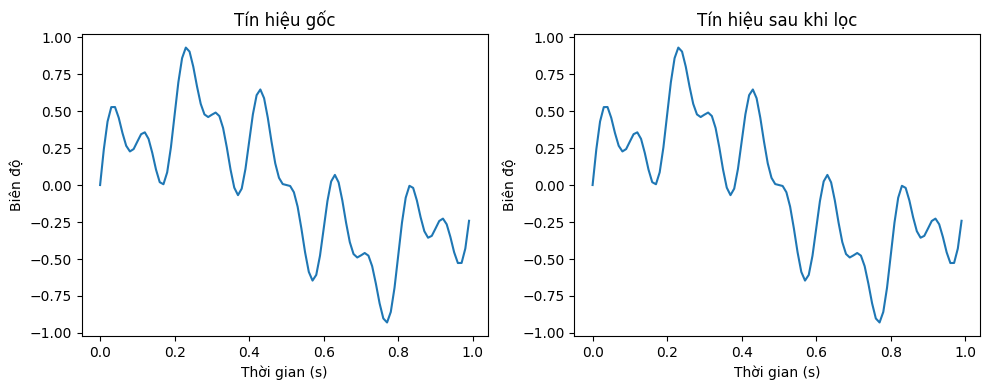

Tín hiệu đã lọc:  [-3.60485209e-17  2.41657409e-01  4.29213496e-01  5.26607059e-01
  5.27218949e-01  4.54508497e-01  3.51822181e-01  2.65383441e-01
  2.27001109e-01  2.43061445e-01  2.93892626e-01  3.43563947e-01
  3.56149281e-01  3.11990519e-01  2.17496717e-01  1.04508497e-01
  1.92899574e-02  5.23693845e-03  8.58666473e-02  2.54626094e-01
  4.75528258e-01  6.94553729e-01  8.57690504e-01  9.28973752e-01
  9.01887370e-01  8.00000000e-01  6.66773269e-01  5.48551146e-01
  4.77267898e-01  4.59439628e-01  4.75528258e-01  4.89740195e-01
  4.66289254e-01  3.85659545e-01  2.54404058e-01  1.04508497e-01
 -1.76173840e-02 -6.84320879e-02 -2.42733260e-02  1.08449846e-01
  2.93892626e-01  4.78175546e-01  6.07423716e-01  6.45806047e-01
  5.86936282e-01  4.54508497e-01  2.92104848e-01  1.46184452e-01
  4.87908892e-02  6.54330762e-03  2.13162821e-16 -6.54330762e-03
 -4.87908892e-02 -1.46184452e-01 -2.92104848e-01 -4.54508497e-01
 -5.86936282e-01 -6.45806047e-01 -6.07423716e-01 -4.78175546e-01
 -2.938

In [27]:
import numpy as np
import matplotlib.pyplot as plt

def filter_signal(signal, sampling_rate, min_freq, max_freq):
    """
    Lọc tín hiệu trong miền tần số để giữ lại tần số trong dải min_freq đến max_freq.
    
    Args:
        signal (np.array): Tín hiệu âm thanh đầu vào.
        sampling_rate (int): Tần số lấy mẫu.
        min_freq (float): Tần số thấp nhất cần giữ lại.
        max_freq (float): Tần số cao nhất cần giữ lại.
        
    Returns:
        np.array: Tín hiệu sau khi lọc.
    """
    # Chuyển tín hiệu từ miền thời gian sang miền tần số bằng FFT
    signal_fft = np.fft.fft(signal)
    
    # Tạo mảng tần số tương ứng với các giá trị trong FFT
    frequencies = np.fft.fftfreq(len(signal), d=1/sampling_rate)

    # Lọc tín hiệu: chỉ giữ các tần số trong phạm vi [min_freq, max_freq]
    # Tìm chỉ số của các tần số trong phạm vi cần giữ
    indices = np.where((frequencies >= min_freq) & (frequencies <= max_freq))

    # Tạo mảng FFT mới, chỉ giữ các tần số trong dải [min_freq, max_freq]
    filtered_signal_fft = np.zeros_like(signal_fft)
    filtered_signal_fft[indices] = signal_fft[indices]
    
    # Đảm bảo giữ tần số đối xứng cho FFT (do FFT là đối xứng)
    filtered_signal_fft[-indices[0]] = np.conj(filtered_signal_fft[indices])

    # Chuyển tín hiệu trở lại miền thời gian bằng IFFT
    filtered_signal = np.fft.ifft(filtered_signal_fft)

    # Chuyển tín hiệu về dạng thực (bỏ phần ảo)
    filtered_signal = np.real(filtered_signal)

    return filtered_signal


# Tạo tín hiệu âm thanh giả lập với các tần số khác nhau
sampling_rate = 100  # Tần số lấy mẫu (100 Hz)
duration = 1  # Thời gian tín hiệu (1 giây)
t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)

# Tạo tín hiệu với các thành phần tần số 1 Hz, 5 Hz, 10 Hz và 50 Hz
signal = 0.5 * np.sin(2 * np.pi * 1 * t) + 0.3 * np.sin(2 * np.pi * 5 * t) + 0.2 * np.sin(2 * np.pi * 10 * t) + 0.4 * np.sin(2 * np.pi * 50 * t)

# Vẽ tín hiệu gốc
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(t, signal)
plt.title('Tín hiệu gốc')
plt.xlabel('Thời gian (s)')
plt.ylabel('Biên độ')

# Lọc các tần số trong dải [min_freq, max_freq] (ví dụ: giữ lại từ 1 Hz đến 10 Hz)
min_freq = 1  # Tần số thấp nhất cần giữ lại
max_freq = 10  # Tần số cao nhất cần giữ lại

# Lọc tín hiệu
filtered_signal = filter_signal(signal, sampling_rate, min_freq, max_freq)

# Vẽ tín hiệu sau khi lọc
plt.subplot(1, 2, 2)
plt.plot(t, filtered_signal)
plt.title('Tín hiệu sau khi lọc')
plt.xlabel('Thời gian (s)')
plt.ylabel('Biên độ')

plt.tight_layout()
plt.show()

# In kết quả tín hiệu sau khi lọc
print("Tín hiệu đã lọc: ", filtered_signal)
